In [103]:
import numpy as np
from SERGIO.GRN import grn_from_human,grn_from_networkx
from SERGIO._sergio import sergio
from SERGIO.MR import mrProfile
import networkx as nx
from collections import defaultdict
import pandas as pd
from SERGIO.GRN._grn import GRN
from SERGIO.GRN._components import Gene, SingleInteraction
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import random
import scperturb
def create_random_graph(N):
    '''N:number of nodes
    Note that the number of nodes in the graph will likely be smaller than N
    Weights sampled from 2 uniform distributions
    '''
    weight_pos = 3
    weight_neg = -weight_pos
    band=1
    frac_pos = 0.5 #fraction of positive links over total
    G = nx.generators.random_k_out_graph(n = N,k = 4,alpha = 0.9)
    largest = max(nx.strongly_connected_components(G), key=len)
    G = G.subgraph(largest).copy()#filter graph to maximum  SCC
    G = nx.DiGraph(G)#remove multi links
    M = len(G.edges())#n. of links
    w1 = np.random.uniform(weight_neg-band,weight_neg+band,int(M*frac_pos))#sample weights from 2 uniform distributions
    w2 = np.random.uniform(weight_pos-band,weight_pos+band,M-len(w1))
    w = np.concatenate([w1, w2])
    random.shuffle(w)#avoid having correlation in the position
    J = nx.adjacency_matrix(G)
    J.data = w
    G = nx.from_scipy_sparse_matrix(J,create_using=nx.DiGraph())
    return G
def draw_net(G,offset = 0.05,**kwargs):
    c =np.array([ c['weight'] for a,b,c in list(G.edges(data=True))])
    edge_color=np.where(c>0,'green','red')
    #nx.draw_circular(G,with_labels=True,edge_color=edge_color,alpha = 0.7,arrowsize = 15,**kwargs)
    nodePos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G,pos=nodePos, label=True)
    nx.draw_networkx_labels(G,pos = nodePos)
    edges = list(G.edges)
    bi_edges = [(a,b) for a,b in edges  if (b,a)in edges]
    non_bi_edges =list(set(edges)-set(bi_edges))
    a,b,c  =zip(*[ (a,b,c['weight']) for a,b,c in list(G.edges(data=True))])
    dic = {(start,stop):col for start,stop,col in zip(a,b,c)}
    #nx.draw_networkx_edges(G,pos = nodePos,edgelist=edges[weight>0],edge_color= 'green',arrowsize = 15,)
    non_bi_weight = np.array([dic[endpoints] for endpoints in non_bi_edges ])
    bi_weight = np.array([dic[endpoints] for endpoints in bi_edges ])
    nx.draw_networkx_edges(G,pos = nodePos,edgelist=np.array(non_bi_edges)[non_bi_weight>0],edge_color= 'green',arrowsize = 20,)
    nx.draw_networkx_edges(G,pos = nodePos,edgelist=np.array(non_bi_edges)[non_bi_weight<0],edge_color= 'red',arrowsize = 10,arrowstyle='-[',alpha = 0.6)
    #draw bi-directional links parallel one another such that they do not overlap
    unique_bi_edges = []
    for start,stop in bi_edges:
        if (stop, start) not in unique_bi_edges:
            unique_bi_edges+=[(start,stop)]
    offset = 0.05
    new_nodePos={}
    for start,end in unique_bi_edges:
        new_nodePos[start] = nodePos[start]-[0,offset]
        new_nodePos[end] = nodePos[end]-[0,offset]
    nx.draw_networkx_edges(G,pos = new_nodePos,edgelist=np.array(bi_edges)[bi_weight>0],edge_color= 'green',arrowsize = 20,)
    new_nodePos={}
    for start,end in unique_bi_edges:
        new_nodePos[start] = nodePos[start]+[0,offset]
        new_nodePos[end] = nodePos[end]+[0,offset]

    nx.draw_networkx_edges(G,pos = new_nodePos,edgelist=np.array(bi_edges)[bi_weight<0],edge_color= 'red',arrowsize = 10,arrowstyle='-[',alpha = 0.6,width = 1.5)


In [104]:
#grn = grn_from_human(nGenes=20)
G = create_random_graph(30)
grn = grn_from_networkx(G)
G = grn.to_networkx()
len(G)
#plt.plot(zip(*Counter(dict(G.in_degree()).values()).items()))

19

In [105]:
def draw_net(G,offset = 0.05,node_size = 1000,**kwargs):
    c =np.array([ c['weight'] for a,b,c in list(G.edges(data=True))])
    edge_color=np.where(c>0,'green','red')
    #nx.draw_circular(G,with_labels=True,edge_color=edge_color,alpha = 0.7,arrowsize = 15,**kwargs)
    nodePos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G,pos=nodePos, label=True,node_size=node_size,node_color='none',edgecolors='#1f78b4')
    nx.draw_networkx_labels(G,pos = nodePos)
    edges = list(G.edges)
    bi_edges = [(a,b) for a,b in edges  if (b,a)in edges]
    non_bi_edges =list(set(edges)-set(bi_edges))
    a,b,c  =zip(*[ (a,b,c['weight']) for a,b,c in list(G.edges(data=True))])
    dic = {(start,stop):col for start,stop,col in zip(a,b,c)}
    #nx.draw_networkx_edges(G,pos = nodePos,edgelist=edges[weight>0],edge_color= 'green',arrowsize = 15,)
    non_bi_weight = np.array([dic[endpoints] for endpoints in non_bi_edges ])
    bi_weight = np.array([dic[endpoints] for endpoints in bi_edges ])
    nx.draw_networkx_edges(G,pos = nodePos,edgelist=np.array(non_bi_edges)[non_bi_weight>0],edge_color= 'green',arrowsize = 20,node_size=node_size)
    nx.draw_networkx_edges(G,pos = nodePos,edgelist=np.array(non_bi_edges)[non_bi_weight<0],edge_color= 'red',arrowsize = 10,node_size=node_size,arrowstyle='-[',alpha = 0.6)
    #draw bi-directional links parallel one another such that they do not overlap
    unique_bi_edges = []
    for start,stop in bi_edges:
        if (stop, start) not in unique_bi_edges:
            unique_bi_edges+=[(start,stop)]
    offset = 0.05
    new_nodePos={}
    for start,end in unique_bi_edges:
        new_nodePos[start] = nodePos[start]-[0,offset]
        new_nodePos[end] = nodePos[end]-[0,offset]
    nx.draw_networkx_edges(G,pos = new_nodePos,edgelist=np.array(bi_edges)[bi_weight>0],edge_color= 'green',arrowsize = 20,)
    new_nodePos={}
    for start,end in unique_bi_edges:
        new_nodePos[start] = nodePos[start]+[0,offset]
        new_nodePos[end] = nodePos[end]+[0,offset]

    nx.draw_networkx_edges(G,pos = new_nodePos,edgelist=np.array(bi_edges)[bi_weight<0],edge_color= 'red',arrowsize = 10,arrowstyle='-[',alpha = 0.6,width = 1.5,node_size=node_size)


In [106]:
grn0 = copy.deepcopy(grn)#it is the grn that I pass to perturbation experiments

In [ ]:

def single_perturbation(grn,mr_profs,target_gene,basal_prod,nCells,cutting = True):
    '''
    Function Description:

    This function perturbs a given gene in a gene regulatory network (GRN) and returns
    the simulated dynamics of the network in response to the perturbation. The perturbation involves
    changing the production rate of the target gene to a given basal level (positive for CRISPRa,
    negative or 0 for CRISPRi), and optionally, cutting incoming edges to the target gene.
    The function returns the simulated gene expression dynamics of the perturbed network.

    Parameters:

    grn: an instance of the GRN class representing the GRN to be perturbed
    mr_profs: an instance of the mrProfile class representing the master regulator profiles of the system
    target_gene: the name of the target gene to be perturbed
    basal_prod: the basal production rate of the target gene after perturbation (positive for CRISPRa, negative or 0 for CRISPRi)
    cutting: a boolean variable indicating whether incoming edges to the target gene should be cut (True) or not (False)
    in response to the perturbation. Default is True.
    Returns:

    sim: an instance of the sergio class representing the simulated gene expression dynamics of the perturbed network.
    
    '''
    new_grn = copy.deepcopy(grn)
    new_grn.attr_['mrs'].add(target_gene)
    links_2_remove = list(filter(lambda x:x.split('-')[1]==target_gene,new_grn.attr_['interactions'].keys()))
    if cutting:
        #identifies the links pointing to gene, and removes them from the net
        [new_grn.attr_['interactions'].pop(link) for link in links_2_remove]#remove interaction from GRN
    
    crispri = copy.deepcopy(mr_profs)
    crispri.profile[target_gene]=basal_prod*np.ones(1)
    new_grn.init(crispri, update_half_resp = True)
    sim = sergio(new_grn)
    sim.simulate(nCells = nCells, noise_s = 1, safety_iter = 150, scale_iter = 10)
    return sim
def perturbation_all(grn,nCells):
    nGenes = len(grn.attr_['genes'])
    store = np.zeros(shape = (2,nGenes,nGenes,nCells))
    #dimension 0 describe the type of perturbation experiment, 0:Crispri, 1: crispra
    #dimension 1 describes the index target gene
    #dimension 2 describe the index of genes whose expression is measured
    #dimension 3 describes the index of cell
    
    '''now simulate wild type'''
    grn0 = copy.deepcopy(grn)#it is the grn that I pass to perturbation experiments
    mrs = grn.get_mrs()
    mr_profs = mrProfile(MR_names = mrs, n_types = 1)
    mr_profs.build_rnd(range_dict={'L': [1, 2.5], 'H': [3.5, 5]})
    grn.init(mr_profs, update_half_resp = True)
    sim = sergio(grn)
    sim.simulate(nCells = nCells, noise_s = 1, safety_iter = 150, scale_iter = 10)
    wt = sim.getSimExpr().values
    for i,target_gene in enumerate(grn.attr_['genes'].keys()):
        #simulate Crispri
        store[0,i]= single_perturbation(grn = grn0,mr_profs=mr_profs,target_gene=target_gene,basal_prod=0.2,nCells=nCells,cutting=True).getSimExpr().values
        #simulate Crispra
        store[1,i]= single_perturbation(grn = grn0,mr_profs=mr_profs,target_gene=target_gene,basal_prod=7,nCells=nCells,cutting=True).getSimExpr().values

    return wt,store
%time wt,store = perturbation_all(grn0,nCells=10000)

In [5]:
store.shape,wt.shape
gene_list = list(grn.attr_['genes'].keys())

In [109]:
[k for k,v in dict(G.in_degree()).items() if v ==1]

['13', '12', '14', '17']

draw network containing 'gene_view', its successors and they other parents

5


,from,to,weight
0,5,2,3.061573
1,5,4,-2.784161


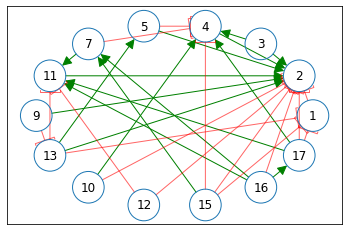

In [110]:
gene_view = '5'#gene_list[1]

print(gene_view)


two_step_neigh = {*itertools.chain.from_iterable([set(G.predecessors(g)) for g in set(G.successors(gene_view))])}
#plt.figure(figsize=(8,8))
draw_net(G.subgraph(two_step_neigh.union(G.successors(gene_view)).union({gene_view})))
pd.DataFrame([[a,b,d['weight']] for a,b,d in list(G.out_edges(gene_view,data=True))],columns=[['from','to','weight']])

In [107]:
5/0.8

6.25

Investigate expression on the target gene

<AxesSubplot:ylabel='Density'>

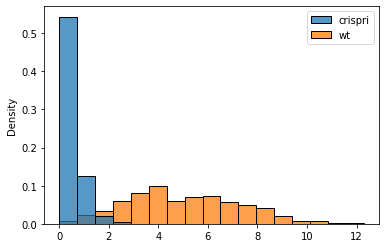

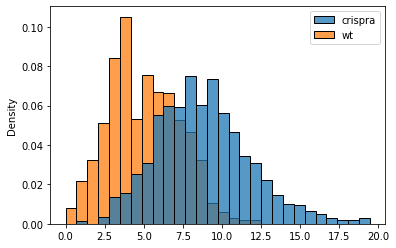

In [111]:
i = np.arange(len(gene_list))[np.array(gene_list)==gene_view][0]# take the index of gene_view
#j = np.arange(len(gene_list))[np.array(gene_list)==list(G.out_edges(gene_view))[0][1]][0]#take the index of one of the genes neighbouring gene_view
j = i
a = pd.DataFrame({'crispri':store[0,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')
plt.figure()
a = pd.DataFrame({'crispra':store[1,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')


<AxesSubplot:ylabel='Density'>

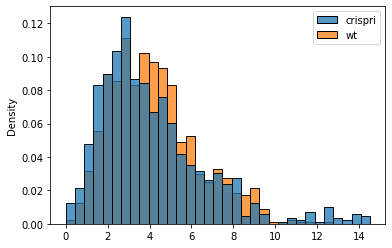

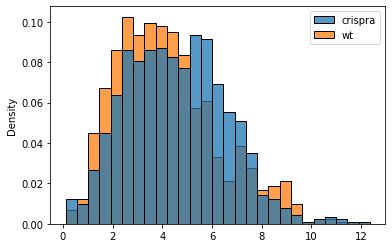

In [112]:
i = np.arange(len(gene_list))[np.array(gene_list)==gene_view][0]# take the index of gene_view
j = np.arange(len(gene_list))[np.array(gene_list)=='2'][0]#take the index of one of the genes neighbouring gene_view
#j = i
a = pd.DataFrame({'crispri':store[0,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')
plt.figure()
a = pd.DataFrame({'crispra':store[1,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')


In [23]:
pd.DataFrame(G.in_edges('9',data = True))


['2', '7', '8', '1', '15', '21', '18']

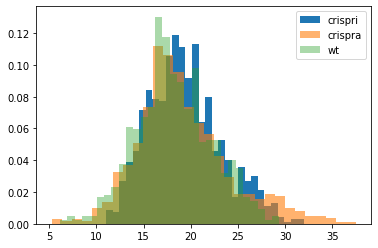

In [38]:
h,b,_ = plt.hist(store[0,i,j],bins =30,label = 'crispri',density = True)

h,b,_ = plt.hist(store[1,i,j],alpha = 0.6,bins = 30,label = 'crispra',density = True)
h,b,_ = plt.hist(wt[j],alpha = 0.4,bins = 30,label = 'wt',density = True)
plt.legend()

In [164]:
pd.DataFrame([[i,v.prod_rates_[0]] for i,v in sim2.grn_.attr_['genes'].items()if v.prod_rates_ is not None] ,columns= ['MR_id','prod_rate'])

,MR_id,prod_rate
0,2737,3.582154
1,4853,4.081881
2,900,5.000000
3,7161,1.538699
4,3135,2.003430
5,3164,1.158086
6,9572,2.282716
7,5598,1.877689
8,5602,4.718141
9,50674,2.268740


In [129]:
sim2.grn_.attr_['genes'][gene]._calc_prod([0], regs_conc = 'sim')
sim2.grn_.attr_['genes'][gene].prod_rates_

array([5.])

In [13]:
sim2.grn_.attr_['genes'][gene].isMR_,sim.grn_.attr_['genes'][gene].isMR_


(True, False)

In [30]:
if sim2.grn_.attr_['genes'][list(non_mr)[0]].prod_rates_ is not None:
    print('None')

None


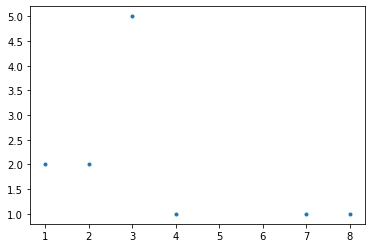

In [156]:
sim2.grn_.attr_['genes'][gene].level,
plt.plot(*zip(*list(Counter([sim2.grn_.attr_['genes'][el].level for el in mrs ]).items())),'.')


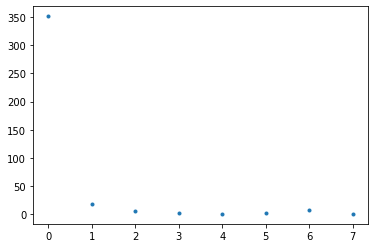

In [159]:
plt.plot(*zip(*list(Counter([sim2.grn_.attr_['genes'][el].level for el in non_mr if el!=gene]).items())),'.')


run etest on Anndata, create a unique anndata with perturbation column. Use p-values to compare with experiments

In [44]:
import scanpy as sc
scperturb.edist_to_control


In [42]:
def edist_to_control(adata, obs_key='perturbation', control='control', 
                     obsm_key='X_pca', dist='sqeuclidean',  
                     flavor=0, verbose=True):
    """Computes the edistance to control.
    Computes the all E-distances between all groups of cells defined in
    adata.obs[obs_key] (e.g. perturbations) and control cells. Distances are computed in embedding
    space given by adata.obsm[obsm_key] (e.g. PCA space).
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    obs_key: `str` in adata.obs.keys() (default: `perturbation`)
        Key in adata.obs specifying the groups to consider.
    obsm_key: `str` in adata.obsm (default: `adata.obsm['X_pca']`)
        Key for embedding coordinates to use.
    dist: `str` for any distance in scipy.spatial.distance (default: `sqeuclidean`)
        Distance metric to use in embedding space.
    flavor: `int` (default: `0`)
        Which flavor of E-distance to use.
        - `0`: E-distance no correction factor
        - `1`: E-distance with simple correction factor (N-1)
        - `2`: E-distance with correction factor NM/(N+M)
        - `3`: E-distance with correction division by delta
    verbose: `bool` (default: `True`)
        Whether to show a progress bar iterating over all groups.
    Returns
    -------
    ed_to_c: pandas.DataFrame
        DataFrame with E-distances between all groups and control group.
    """
    correction_factor = flavor==1
    deltas_to_c = onesided_pca_distances(adata, obs_key=obs_key, control=control, 
                                         obsm_key=obsm_key, dist=dist, 
                                         correction_factor=correction_factor, 
                                         verbose=verbose)
    sigmas = self_pca_distances(adata, obs_key, obsm_key=obsm_key, dist=dist, 
                                correction_factor=correction_factor, verbose=False)
    # derive basic statistics
    ed_to_c = 2 * deltas_to_c - sigmas - sigmas.loc[control]
    if flavor == 2:
        sizes = np.array([np.sum(adata.obs[obs_key]==g) for g in sigmas.index])
        corrections = (sizes * sizes[sigmas.index==control]) / (sizes + sizes[sigmas.index==control])
        ed_to_c = ed_to_c * corrections.reshape(-1,1)
    if flavor == 3:
        ed_to_c = ed_to_c / deltas_to_c
    return ed_to_c